In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('Predict_Academic_Success_Modified.csv')

# Convert categorical columns to numerical using Label Encoding
categorical_columns = ["Previous qualification", "Mother's qualification", "Father's qualification", "Nacionality",
                    "Mother's occupation", "Father's occupation", "Marital status", "Application mode",
                    "Course", "Daytime/evening attendance", "Displaced", "Educational special needs", 
                    "Debtor", "Tuition fees up to date", "Gender", "Scholarship holder", "International"]
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Save encoder in case we need to transform new data

In [15]:
# Convert the target using Label Encoding ('Dropout', 'Enrolled', 'Graduate')
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

In [16]:
# 90% for training/testing, 10% for unseen validation
train_test_data, unseen_data = train_test_split(data, test_size=0.10, random_state=42, stratify=data["Target"])

In [17]:
# Split the 90% into 80% training and 20% testing
train_data, test_data = train_test_split(
    train_test_data, test_size=0.20, random_state=42, stratify=train_test_data["Target"]
)

In [18]:
# Separate features and target variables
X_train = train_data.drop(columns=["Target"])
y_train = train_data["Target"]
X_test = test_data.drop(columns=["Target"])
y_test = test_data["Target"]

In [19]:
# Initialize Naive Bayes model
nb_model = GaussianNB()

Cross-validation accuracy scores: 
[0.70532915 0.66144201 0.69592476 0.68338558 0.72641509 0.76100629
 0.69496855 0.64779874 0.68553459 0.73899371]


Evaluation Metrics:


,Metric,Score
0,Mean cross-validation accuracy,0.700080
1,Accuracy:,0.691343
2,Precision:,0.678075
3,Recall:,0.691343
4,ROC-AUC:,0.793278


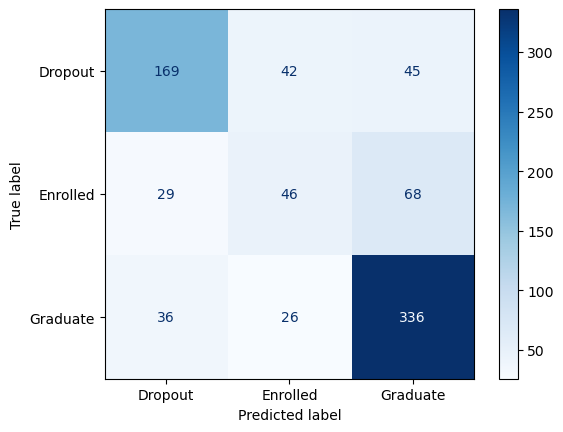

In [20]:
# Apply 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(nb_model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy scores: \n{cross_val_scores}\n")


# Train the model
nb_model.fit(X_train, y_train)

# Make predictions
y_pred = nb_model.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, nb_model.predict_proba(X_test), multi_class="ovr")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for the evaluation metrics
results_df = pd.DataFrame({
    "Metric": ["Mean cross-validation accuracy","Accuracy:", "Precision:", "Recall:", "ROC-AUC:"],
    "Score": [cross_val_scores.mean(),accuracy, precision, recall, roc_auc]
})




# Display Confusion Matrix of testing data
class_names = ['Dropout', 'Enrolled', 'Graduate']
df_unseen_metrics = pd.DataFrame(conf_matrix)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=class_names, cmap=plt.cm.Blues
)
# Print the results in tabular form
print("\nEvaluation Metrics:")
results_df

In [21]:
# Load the unseen 10% dataset
X_unseen = unseen_data.drop(columns=["Target"])
y_unseen = unseen_data["Target"]

In [22]:
# Use the trained model to predict outcomes for the unseen data
y_unseen_pred = nb_model.predict(X_unseen)


Confusion Matrix for Unseen Data:

          Dropout  Enrolled  Graduate
Dropout        94        33        15
Enrolled       13        27        40
Graduate       14        25       182

Unseen Data Evaluation Metrics:



,Metric,Score
0,Cross-Validation Accuracy,0.693465
1,Accuracy,0.683973
2,Precision,0.689478
3,Recall,0.683973
4,ROC-AUC,0.829791


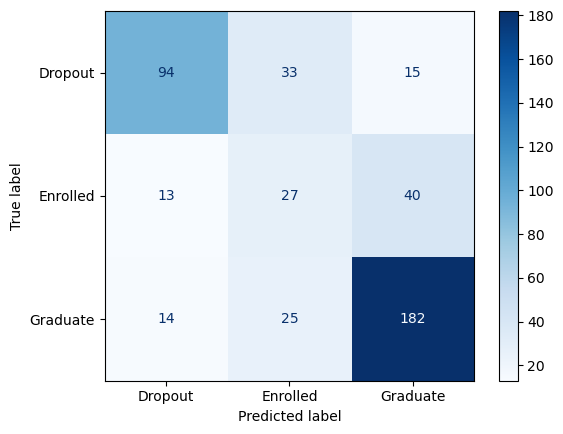

In [25]:
# Cross-Validation Accuracy
cv_accuracy = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='accuracy').mean()

# Accuracy
unseen_accuracy = accuracy_score(y_unseen, y_unseen_pred)

# Precision
unseen_precision = precision_score(y_unseen, y_unseen_pred, average='weighted')

# Recall
unseen_recall = recall_score(y_unseen, y_unseen_pred, average='weighted')

# ROC-AUC Score
unseen_roc_auc = roc_auc_score(y_unseen, nb_model.predict_proba(X_unseen), multi_class="ovr")

# Confusion Matrix
unseen_conf_matrix = confusion_matrix(y_unseen, y_unseen_pred)

# Create evaluation metrics DataFrame
unseen_results_df = pd.DataFrame({
    "Metric": ["Cross-Validation Accuracy", "Accuracy", "Precision", "Recall", "ROC-AUC"],
    "Score": [cv_accuracy, unseen_accuracy, unseen_precision, unseen_recall, unseen_roc_auc]
})



# Display Confusion Matrix
unseen_conf_matrix_df = pd.DataFrame(unseen_conf_matrix, 
                                     index=label_encoder.classes_, 
                                     columns=label_encoder.classes_)

print("\nConfusion Matrix for Unseen Data:\n")
print(unseen_conf_matrix_df)

# Calculate matches (diagonal values)
matches = np.diag(unseen_conf_matrix)

# Calculate mismatches (row sum - diagonal)
mismatches = unseen_conf_matrix.sum(axis=1) - matches

# Display Confusion Matrix of testing data
class_names = ['Dropout', 'Enrolled', 'Graduate']
df_unseen_metrics = pd.DataFrame(unseen_conf_matrix)
disp = ConfusionMatrixDisplay.from_predictions(
    y_unseen, y_unseen_pred, display_labels=class_names, cmap=plt.cm.Blues
)
print("\nUnseen Data Evaluation Metrics:\n")
unseen_results_df

In [24]:
# Create reformatted confusion matrix DataFrame
unseen_conf_summary_df = pd.DataFrame({
    "Category": label_encoder.classes_,
    "Matches": matches,
    "Mismatches": mismatches
})
print("\nActual Vs Predicted:\n")
unseen_conf_summary_df


Actual Vs Predicted:



,Category,Matches,Mismatches
0,Dropout,94,48
1,Enrolled,27,53
2,Graduate,182,39
